In [1]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import GroupShuffleSplit


# Ensure reproducibility'
np.random.seed(42)
#tf.random.set_seed(42)
tf.random.set_random_seed(42)
# Material constants
E = 193000e6  # Young's modulus in MPa
sigma_y = 150e6  # Yield stress in MPa
c1, c2, c3 = 230000e6, 19600e6, 1800e6  # Kinematic hardening constants
gamma1, gamma2, gamma3 = 1200, 140, 4  # Hardening constants
b = 8  # Isotropic hardening rate
Q = 110e6  # Isotropic hardening saturation value



# Generate strain history byappointment islamabad accumulating increments
def generate_strain_history(num_samples, lb, ub):
    strain_history = np.zeros(num_samples)
    cumulative_strain = 0  # Start with zero cumulative strain

    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = np.random.uniform(lb, ub)
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    # Third range: Return to positive strain increments
    for i in range(900, num_samples):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    return strain_history



# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    back_stress = sigma_k1 + sigma_k2 + sigma_k3
    yield_function = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
    return sigma_trial, yield_function

# Update kinematic hardening rule
def update_kinematic_hardening(sigma_k, eps_p_dot, c, gamma):
    return (2.0 / 3.0) * c * eps_p_dot - gamma * sigma_k * np.abs(eps_p_dot)

# Update isotropic hardening rule
def update_isotropic_hardening(sigma_i, eps_p_dot, b, Q):
    return b * (Q - sigma_i) * np.abs(eps_p_dot)

# Return mapping algorithm
def return_mapping(eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        return sigma_trial, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i
    else:
        # Plastic corrector step
        def plastic_residual(delta_gamma):
            eps_p_dot = delta_gamma
            back_stress = sigma_k1 + sigma_k2 + sigma_k3
            sigma_updated = sigma_trial - E * delta_gamma
            yield_function_updated = np.abs(sigma_updated - back_stress) - (sigma_y + sigma_i + b * delta_gamma)
            return yield_function_updated

        try:
            delta_gamma = newton(plastic_residual, 1e-5, tol=1e-5, maxiter=50)  # Solve for plastic multiplier
        except RuntimeError:
            delta_gamma = 0.0  # If Newton-Raphson fails, assume no plastic deformation

        eps_p += delta_gamma
        sigma_k1 += update_kinematic_hardening(sigma_k1, delta_gamma, c1, gamma1)
        sigma_k2 += update_kinematic_hardening(sigma_k2, delta_gamma, c2, gamma2)
        sigma_k3 += update_kinematic_hardening(sigma_k3, delta_gamma, c3, gamma3)
        sigma_i += update_isotropic_hardening(sigma_i, delta_gamma, b, Q)

        # Final stress update
        sigma_updated = sigma_trial - E * delta_gamma
        return sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i


# Generate dataset
def generate_dataset(lb, ub, num_strain_samples):
    dataset = []
    strain_history = generate_strain_history(num_strain_samples, lb, ub)

    # Initialize state variables
    sigma_k1, sigma_k2, sigma_k3, sigma_i, eps_p = 0, 0, 0, 0, 0

    for eps in strain_history:
        # Elastic predictor
        sigma_trial, yield_function = elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)

        # Return mapping algorithm
        sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
            eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, E, sigma_y
        )

        # Store the data
        back_stress = sigma_k1 + sigma_k2 + sigma_k3
        trial_phi = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
        #trial_phi= yield_function
        dataset.append([
            E, sigma_y, c1, gamma1, c2, gamma2, c3, gamma3, 
            b, Q, trial_phi, eps, sigma_updated, np.abs(eps_p)
        ])

    return np.array(dataset)


# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_training20.11.csv"):
    columns = [E, sigma_y, c[0],gamma[0], c[1],gamma[1], c[2],gamma[2],
                b, Q, trial_phi,
                strain,          # Strain
                stress_rm,    # Stress from Return Mapping
                plastic_strain]
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")



In [2]:
# Split dataset into training and testing sets
def split_dataset(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
def normalize_dataset(data, scaler=None):
    if scaler is None:
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(data)
    else:
        normalized_data = scaler.transform(data)
    return normalized_data, scaler

In [4]:
# Build the neural network
def build_model(input_dim):
    model = Sequential([
        Dense(10, activation='sigmoid', input_shape=(input_dim,)),  # Use 10 neurons, sigmoid activation
        #Dense(10, activation='sigmoid'),  # Second hidden layer also with 10 neurons
        Dense(1, activation='linear')     # Linear activation for the output
    ])
    custom_adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=custom_adam, loss='mean_squared_error', metrics=['mae'])
    return model

In [5]:
# Plot training and validation loss
def plot_loss(history, filename='loss_curve.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    #plt.savefig(filename)  # Save the plot as an image file
    #plt.close()  # Close the plot to avoid displaying it in the notebook
    #print(f"Loss curve saved as {filename}")

# Plot predicted vs original values
def plot_predicted_vs_actual(y_test, y_pred, filename='predicted_vs_actual.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Original Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Sample index')
    plt.ylabel('Plastic Strain')
    plt.title('Predicted vs. Original Plastic Strain')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('predicted_vs_actual')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebookLHSLHS
    print(f"Plot saved as {'predicted_vs_actual'}")

In [6]:
training = generate_dataset(lb=0.0001,ub=0.0002, num_strain_samples=1500)
test1 = generate_dataset(lb=0,ub=0.0001, num_strain_samples=1500)
test2 = generate_dataset(lb=0.0002,ub=0.0004, num_strain_samples=1500)

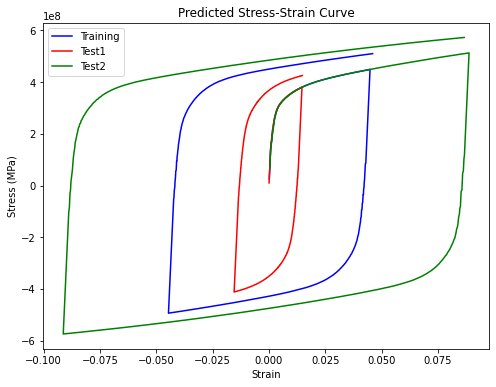

In [7]:
# Plot predicted stress vs strain
plt.figure(figsize=(8, 6))
#plt.plot(strain_values_test, stress_values_predicted, label='Predicted Stress', color='red')
plt.plot(training[:,11], training[:,-2], label='Training', color='blue')
plt.plot(test1[:,11], test1[:,-2], label='Test1', color='red')
plt.plot(test2[:,11], test2[:,-2], label='Test2', color='green')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Predicted Stress-Strain Curve')
plt.legend()

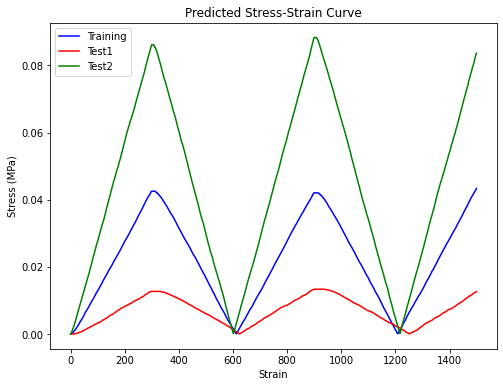

In [8]:
# Plot predicted stress vs strain
plt.figure(figsize=(8, 6))
#plt.plot(strain_values_test, stress_values_predicted, label='Predicted Stress', color='red')
plt.plot( training[:,-1], label='Training', color='blue')
plt.plot( test1[:,-1], label='Test1', color='red')
plt.plot(test2[:,-1], label='Test2', color='green')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Predicted Stress-Strain Curve')
plt.legend()

In [9]:
plastic_strain_training= training[:,-1]
plastic_strain_test1= test1[:,-1]
plastic_strain_test2= test2[:,-1]

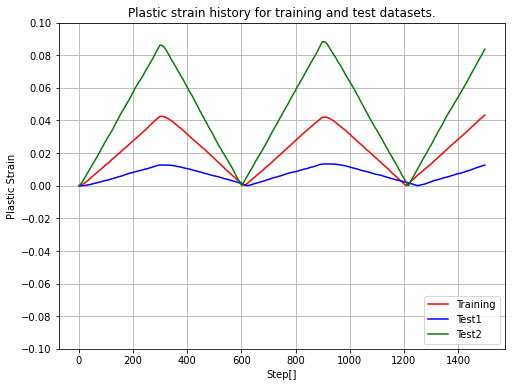

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(plastic_strain_training, label='Training', color='red')
plt.plot(plastic_strain_test1, label='Test1', color='blue')
plt.plot(plastic_strain_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Plastic Strain')
plt.title('Plastic strain history for training and test datasets.')

y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [11]:
training_normalized, scaler = normalize_dataset(training)

In [12]:
columns = ['E', 'sigma_y', 'c[0]','gamma[0]', 'c[1]','gamma[1]', 'c[2]','gamma[2]','b', 'Q', 'trial_phi',
            'strain',          # Strain
            'stress_rm',    # Stress from Return Mapping
            'plastic_strain']
df = pd.DataFrame(training, columns=columns)

In [13]:
df.tail(5)

,E,sigma_y,c[0],gamma[0],c[1],gamma[1],c[2],gamma[2],b,Q,trial_phi,strain,stress_rm,plastic_strain
1495,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,3.181632e+07,0.045356,5.095104e+08,0.042716
1496,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,3.087481e+07,0.045518,5.097040e+08,0.042877
1497,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,2.788824e+07,0.045664,5.098918e+08,0.043022
1498,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,2.630071e+07,0.045802,5.100612e+08,0.043159
1499,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,3.558668e+07,0.045988,5.102209e+08,0.043345


In [14]:
# Separate features and target
X = training_normalized[:, :-2]  # Features (E, sigma_y, c1, c2, c3, gamma1, gamma2, gamma3, b, Q, strain)
y = training_normalized[:, -1]   # Targets (plastic_strain)

In [15]:
X[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.37125657, 0.49386272])

In [16]:
# Build the neural network model
print("Building the neural network model...")
model = build_model(X.shape[1])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor the validation loss
    patience=20,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with early stopping
print("Training the model...")
history = model.fit(
    X, 
    y, 
    epochs=1000,               # Set a large number of epochs
    batch_size=1000,
    validation_split=0.2, 
    callbacks=[early_stopping],  # Include the early stopping callback
    verbose=1
)

Building the neural network model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Training the model...
Train on 1200 samples, validate on 300 samples
Epoch 1/1000
1200/1200 [==============================] - 0s 152us/sample - loss: 0.1099 - mean_absolute_error: 0.2785 - val_loss: 0.0884 - val_mean_absolute_error: 0.2540
Epoch 2/1000
1200/1200 [==============================] - 0s 5us/sample - loss: 0.1057 - mean_absolute_error: 0.2744 - val_loss: 0.0859 - val_mean_absolute_error: 0.2516
Epoch 3/1000
1200/1200 [==============================] - 0s 6us/sample - loss: 0.1020 - mean_absolute_error: 0.2708 - val_loss: 0.0839 - val_mean_absolute_error: 0.2498
Epoch 4/1000
1200/1200 [==============================] - 0s 9us/sample - loss: 0.0988 - mean_absolute_error: 0.2677 - val_loss: 0.0824 - val_mean_absolute_error: 0.2483
Epoch 5/1000
1200/1200 [==============================] - 0s 4us/sample - loss: 0.0961 - mean_

Evaluating the model on the test set...
Making predictions on the test set...


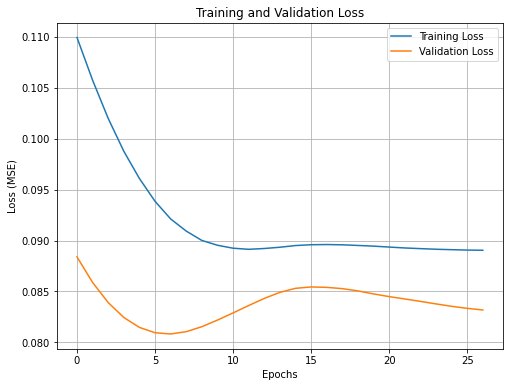

In [17]:
# Evaluate the model on the test set
print("Evaluating the model on the test set...")
#test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
#print(f"Test MAE: {test_mae}")

# Make predictionsarr_reduced = arr[0, :]
print("Making predictions on the test set...")
y_pred_normalized = np.abs(model.predict(X))

# Denormalize predictions and actual values
#scaler1= MinMaxScaler()
#y_pred_denormalized = scaler.inverse_transform(y_pred_normalized).flatten()
#y_test_denormalized = scaler_y.inverse_transform(y_test).flatten()

# Save the model
#model.save('plastic_strain_predictor_model.h5')
#print("Model saved as 'plastic_strain_predictor_model.h5'")

# Plot training and validation loss
plot_loss(history, filename='loss_curve.png')

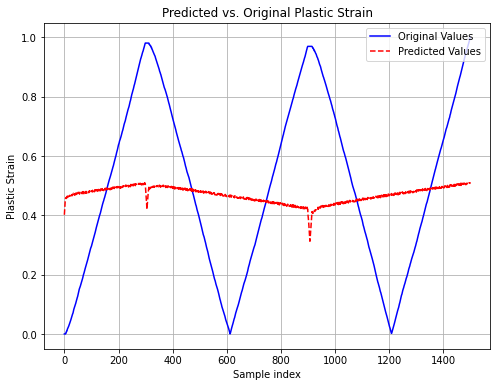

Plot saved as predicted_vs_actual


In [18]:
# Plot predicted vs original plastic strain
plot_predicted_vs_actual(y, y_pred_normalized, filename='predicted_vs_actual.png')

In [19]:
strain_values_test = training_normalized[:,11]

In [20]:
y_pred_normalized_nn = np.squeeze(y_pred_normalized)

In [21]:
stress_values_predicted =training[:,0][0]*(strain_values_test - y_pred_normalized_nn)

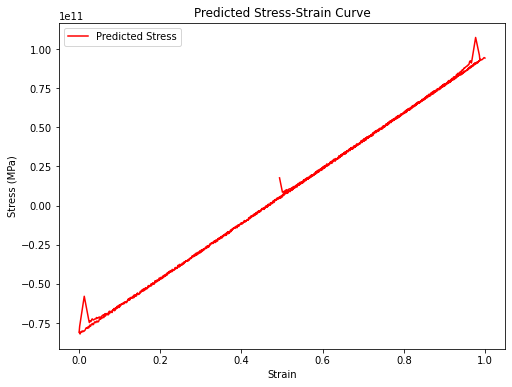

In [22]:
# Plot predicted stress vs strain
plt.figure(figsize=(8, 6))
plt.plot(strain_values_test, stress_values_predicted, label='Predicted Stress', color='red')
#plt.plot(strain_values_test, df_test['stress_rm'], label='Actual Stress', color='blue')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Predicted Stress-Strain Curve')
plt.legend()

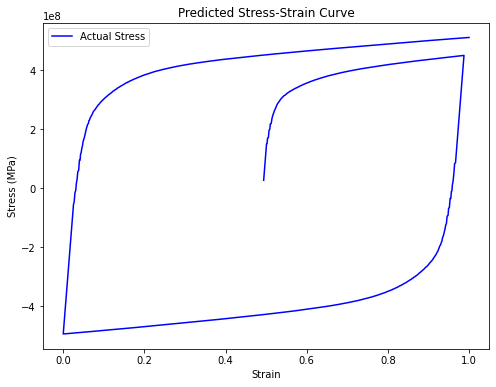

In [23]:
# Plot predicted stress vs strain
plt.figure(figsize=(8, 6))
#plt.plot(strain_values_test, stress_values_predicted, label='Predicted Stress', color='red')
plt.plot(strain_values_test, training[:,-2], label='Actual Stress', color='blue')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Predicted Stress-Strain Curve')
plt.legend()

In [24]:
stress_values_predicted_reverse = 193000e6*(training[:,11]- training[:,-1])

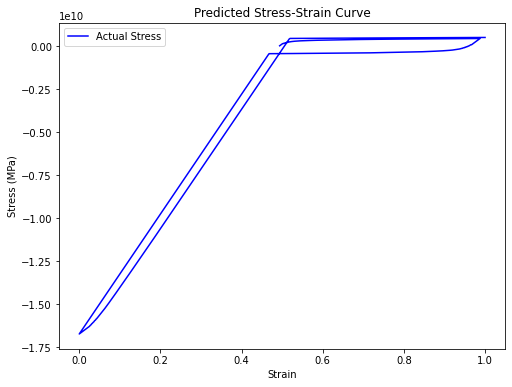

In [25]:
# Plot predicted stress vs strain
plt.figure(figsize=(8, 6))
#plt.plot(strain_values_test, stress_values_predicted, label='Predicted Stress', color='red')
plt.plot(strain_values_test,stress_values_predicted_reverse, label='Actual Stress', color='blue')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Predicted Stress-Strain Curve')
plt.legend()